# Import lib, modules

In [1]:
import torch
from datasets.mrc_ner_dataset_vlsp_fastai import SentenceTransform, YTransform, BeforeBatchTransform
from utils.read_file import load_jsonl
from transformers import PhobertTokenizer
from fastai.text.all import (
    Datasets,
    tensor,
    Learner,
    EarlyStoppingCallback, SaveModelCallback, ReduceLROnPlateau,
)
import os
from models.phobert_query_ner import PhoBertQueryNER, splitter
from models.query_ner_config import PhobertQueryNerConfig
from loss.loss_func_fastai import CustomLoss
from metrics.query_span_f1_fastai import QuerySpanF1

# Config

In [2]:
# Config
bert_model = 'vinai/phobert-base'
bert_dropout = 0.1
mrc_dropout = 0.3
loss_type = 'bce'   # bce, dice
flat_ner = False
span_loss_candidates = 'pred_and_gold' # all, pred_and_gold, gold
max_length = 210
batch_size = 2
weight_decay = 0.01
weight_start = 1.0
weight_end = 1.0
weight_span = 0.1
data_dir = 'data/vlsp_processed'

# Data

## Load data

In [3]:
train_data = load_jsonl(os.path.join(data_dir, 'train.jsonl'))
valid_data = load_jsonl(os.path.join(data_dir, 'dev.jsonl'))
test_data = load_jsonl(os.path.join(data_dir, 'test.jsonl'))

## Data Pipeline

In [4]:
train_valid_data = [*train_data, *valid_data]
n_samples = len(train_valid_data)

In [5]:
splits = (list(range(len(train_data))), range(len(train_data), n_samples))

In [6]:
tokenizer = PhobertTokenizer.from_pretrained(bert_model)

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [7]:
sent_tfms = SentenceTransform(
    tokenizer=tokenizer,
    possible_only=False,
)

In [ ]:
data = [sent_tfms(i) for i in train_valid_data]

In [8]:
test_data = [sent_tfms(i) for i in test_data]

### Save data

In [9]:
# torch.save(data, 'train_valid_data.pkl')
# torch.save(test_data, 'test_data.pkl')

In [8]:
data = torch.load('train_valid_data.pkl')
test_data = torch.load('test_data.pkl')

## Dataset

In [9]:
x_tfms = [lambda x: x['token_ids'], tensor]
y_tfms = [YTransform()]
ds = Datasets(
    data,
    splits=splits,
    tfms=[x_tfms, y_tfms],
    n_inp=1,
)

In [10]:
ds[0], ds.show(ds[0])

((tensor([    0, 14110,    18,   646,   221,     4,   221,  6143,     6,    86,
              7,    18,     4,   221,  2044,     4,  1116, 18395,     4, 38207,
              2,  2522,   985,    26,  2796,     2]),
  (tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0]),
   tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0]),
   tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
           1, 0]),
   tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
           1, 0]),
   tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Dataloader

In [11]:
dls = ds.dataloaders(
    bs=batch_size,
    before_batch=BeforeBatchTransform(
        max_seq_length=max_length,
        pad_fields=[0, 1, 2, 3, 4],
        pad_values=[tokenizer.pad_token_id, 0, 0, 0, 0],
        pad_token_id=tokenizer.pad_token_id,
        sep_token_id=tokenizer.sep_token_id,
    ),
    n_inp=1,
    verbose=5,
)

Setting up after_item: Pipeline: 
Setting up before_batch: Pipeline: BeforeBatchTransform
Setting up after_batch: Pipeline: 


In [12]:
dls.one_batch()

(tensor([[    0, 14110,   646,  5267,     4,  2877,     4,  6146,     4,  1674,
              4,   110,   201,     2,  1615, 16491,     4,  8094, 37513,     4,
           2124,   736,   621,     4,  1601,   125,   367,    81,   639,   247,
             14,    30,   342,   247,    35,   367,    98,  5291,     5,     2],
         [    0, 14110,   646,  5267,     4,  2877,     4,  6146,     4,  1674,
              4,   110,   201,     2,  1351,   174,     4,  1755,    74,    50,
             10,   204,    36,  1205,    24,    86, 30716, 38850,     4,    12,
           1445,   424,   332,   734,  1567,     5,     2,     1,     1,     1]],
        device='cuda:0'),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'),
 tensor([[0, 0, 0, 0, 0, 0, 0,

In [13]:
class WrapperPhoBertQueryNER(PhoBertQueryNER):
    def forward(self, tokens):
        attention_mask = (tokens != self.pad_token_id).long()
        return super().forward(input_ids=tokens, token_type_ids=None, attention_mask=attention_mask)

In [14]:
model_config = PhobertQueryNerConfig.from_pretrained(
    bert_model,
    hidden_dropouy_prob=bert_dropout,
    attention_probs_dropout_prob=bert_dropout,
    mrc_dropout=mrc_dropout,
)

In [15]:
model = WrapperPhoBertQueryNER.from_pretrained(bert_model, config=model_config)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing WrapperPhoBertQueryNER: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing WrapperPhoBertQueryNER from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WrapperPhoBertQueryNER from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of WrapperPhoBertQueryNER were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['start_outputs.weight', 'start_outputs.bias', 'end_outputs.weight', 'end_outputs.bias', 'span_embeddi

In [16]:
loss_func = CustomLoss(
    weight_start=weight_start,
    weight_end=weight_end,
    weight_span=weight_span,
    span_loss_candidates=span_loss_candidates,
    loss_type=loss_type,
)

In [17]:
learner = Learner(
    dls=dls,
    model=model,
    loss_func=loss_func,
    splitter=splitter,
    metrics=[QuerySpanF1(flat=flat_ner),],
    cbs=[
        EarlyStoppingCallback(
            monitor='query_span_f1',
            min_delta=1e-4,
            patience=10,
        ),
        SaveModelCallback(
            monitor='query_span_f1',
            min_delta=1e-4,
            fname='best_query_span_f1_model',
            with_opt=True,
        ),
        ReduceLROnPlateau(monitor='valid_loss', min_delta=1e-4, patience=2),
    ],
    wd=weight_decay,
)

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.10000000149011612)

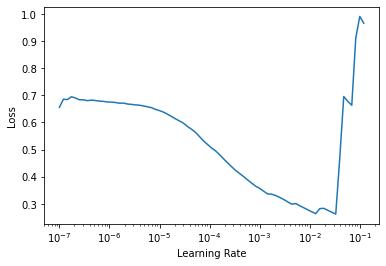

In [18]:
learner.lr_find()